# Breast cancer classification

## Table of Contents
1. [Introduction](#1.-Introduction)
2. [Data Exploration and Pre-Processing](#2.-Data-Exploration-and-Pre-Processing)
3. [Classification](#3.-Classification)
3. [References](#4.-References)

In [119]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Introduction

The Breast Cancer Wisconsin (Original) dataset (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) from UCI machine learning repository is a classification dataset, which records the measurements for breast cancer cases.<br>There are two classes, benign and malignant. This dataset has dimensionality 9.<br>The malignant class of this dataset is considered as outliers, while points in the benign class are considered inliers.<br><br>The aim of this work is to classify breast cancer records in the provided dataset to determine wether a tumor is benignat or malignant. <br>
Features in this dataset are mostly referred to cells of the human body, describing their size. 

## 1.1. Dataset Feature Description and Analisys

- **Sample code number**: code number used to identify patients 
- **Clump Thickness**: Benign cells tend to be grouped in monolayers, while cancerous cells are often grouped in multilayers. 
- **Uniformity of Cell Size**: Cancer cells tend to vary in size
- **Uniformity of Cell Shape**: Cancer cells tend to vary in shape
- **Marginal Adhesion**: Normal cells tend to stick together. Cancer cells tends to lose this ability: loss of adhesion is a sign of malignancy. 
- **Single Epithelial Cell Size**: related to the uniformity mentioned above. Epithelial cells that are significantly enlarged may be malignant. 
- **Bare Nuclei**: Nuclei which are not surrounded by cytoplasm (i.e. the rest of the cell). Those are typically seen in benign tumors.
- **Bland Chromatin**: Describes a uniform "texture" of the nucleus seen in benign cells. In cancer cells the chromatin tends to be more coarse
- **Normal Nucleoli**:  Nucleoli are small structures seen in the nucleus. In normal cells the nucleolus is usually very small if visible at all. In cancer cells the nucleoli become more prominent, and sometimes there are more of them.
- **Mitoses**: Nuclear division plus cytokinesis which produces two identical cell daughters. Mitosis is more frequent and disregulated in cancer cells than in healthy ones
- **Class**: classification of the cancer : 2 for benign, 4 for malignant


In [100]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import random
import os
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, make_scorer, plot_confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA
!pip install mlxtend
from mlxtend.plotting import plot_decision_regions

In [9]:
# in order to reproduce results
SEED = 27
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 2. Data Exploration and Pre-Processing

## 2.0. Prepare dataset

Is is important to split the data before doing any kind of analysis; our attention must be focused only on the training set because we need to have a reliable and not biased point of view about the performance that we will obtain.

In [10]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', header=None)
data.columns = ['Sample code', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                'Normal Nucleoli', 'Mitoses','Class']
data = data.drop(['Sample code'], axis=1)

# Class==2 is Bening, modify it to 0
# Class==4 is Malignant, modify it to 1
data['Class'] = data['Class'].replace([2], 0)
data['Class'] = data['Class'].replace([4], 1)

data_train, data_test = train_test_split(data, test_size=0.20, random_state=SEED)

print('Total number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1] - 1))
print('\nTRAINING    number of instances = %d' % (data_train.shape[0]))
print('TEST        number of instances = %d' % (data_test.shape[0]))
data_train.head()

Total number of instances = 699
Number of attributes = 9

TRAINING    number of instances = 559
TEST        number of instances = 140


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
200,9,7,7,5,5,10,7,8,3,1
23,8,4,5,1,2,?,7,3,1,1
574,10,9,7,3,4,2,7,7,1,1
581,5,7,10,6,5,10,7,5,1,1
525,3,1,1,2,2,1,1,1,1,0


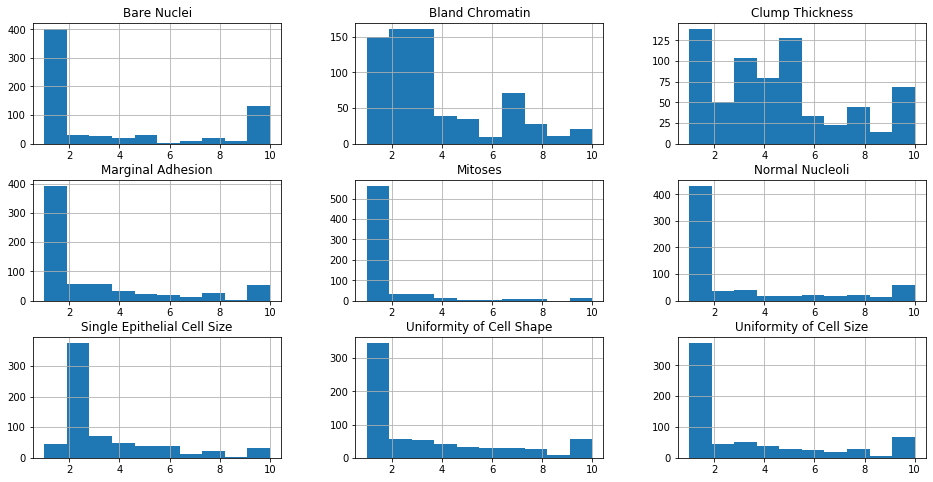

In [11]:
# NOTE: even if missing values are discussed and handled
#  in section below, we temporarily need to handle them 
#  here in order to correctly all the attribute values
data.replace('?', np.NaN).dropna().astype('int64').drop(['Class'], axis=1).hist(figsize=(16, 8))
plt.show()

As we can observe from the plots, all values range from 1 to 10 so we do not need to scale the dataset

## 2.1. Data cleaning

### 2.1.1. Missing Values

According to the description of the data (http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names), there are missing values encoded via '?'.<br>There are several ways to handle missing values, such as removing the corresponding sample or to replace the missing value with the median along  the corresponding attribute. In our case, since there are only few samples affected by missing values, we decided to remove that samples.

In [12]:
data_train = data_train.replace('?', np.NaN)
print('Number of missing values per attribute:')
for col in data_train.columns:
    print('\t{:<30}: {}'.format(col, data_train[col].isna().sum()))
    
print('\nNumber of rows in original data = %d' % (data_train.shape[0]))
data_train = data_train.dropna()
print('Number of rows after discarding missing values = %d' % (data_train.shape[0]))

data_train = data_train.astype('int64')

# drop missing values also in test set
data_test = data_test.replace('?', np.NaN)
data_test = data_test.dropna()
data_test = data_test.astype('int64')

Number of missing values per attribute:
	Clump Thickness               : 0
	Uniformity of Cell Size       : 0
	Uniformity of Cell Shape      : 0
	Marginal Adhesion             : 0
	Single Epithelial Cell Size   : 0
	Bare Nuclei                   : 14
	Bland Chromatin               : 0
	Normal Nucleoli               : 0
	Mitoses                       : 0
	Class                         : 0

Number of rows in original data = 559
Number of rows after discarding missing values = 545


### 2.1.2. Outliers

Outliers are data instances with characteristics that are considerably different from the rest of the dataset. In the example code below, we will draw a boxplot to identify the columns in the table that contain outliers.<br>

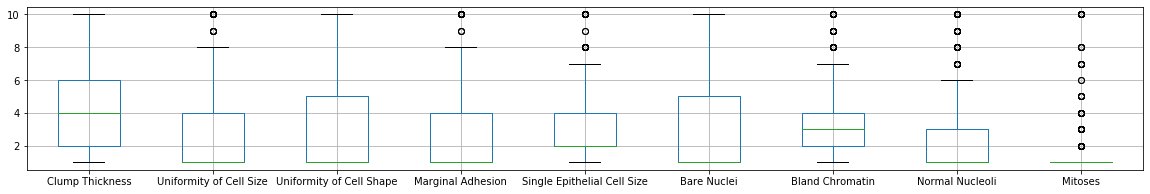

In [13]:
data_train.drop(['Class'], axis=1).boxplot(figsize=(20,3))
plt.show()

The boxplots suggest that 6 of the columns (Uniformity of Cell Size, Marginal Adhesion, Single Epithetial Cell Size, Bland Cromatin, Normal Nucleoli and Mitoses) contain abnormally high values.<br>To discard the outliers, we can compute the Z-score for each attribute and remove those instances containing attributes with abnormally high or low Z-score (e.g., if Z > 3 or Z <= -3).

In [14]:
print('Number of rows before discarding outliers = %d' % (data_train.shape[0]))

THRESHOLD = 3
NUM_ATTRIBUTES = data_train.shape[1]

Z = (data_train - data_train.mean()) / data_train.std()
idx_valid_samples = ((Z > -THRESHOLD).sum(axis=1)==NUM_ATTRIBUTES) & ((Z <= THRESHOLD).sum(axis=1)==NUM_ATTRIBUTES)
data_train = data_train.loc[idx_valid_samples, :]
print('Number of rows after discarding missing values = %d' % (data_train.shape[0]))

Number of rows before discarding outliers = 545
Number of rows after discarding missing values = 507


### 2.1.3. Duplicate samples

According to the dataset description (http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names), this dataset has been obtained by merging multiple data sources, hence it may contain duplicates or near duplicate instances.<br>It is interesting to note that the duplicate data may come from the same patient, however it is always a good choice to drop duplicate data

In [15]:
dups = data_train.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print('\nNumber of rows before discarding duplicates = %d' % (data_train.shape[0]))
data_train = data_train.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data_train.shape[0]))

# drop duplicates also in test set
data_test = data_test.drop_duplicates()

Number of duplicate rows = 184

Number of rows before discarding duplicates = 507
Number of rows after discarding duplicates = 323


### 2.1.4. Correlated attributes

Data correlation is a way to understand the correlation between multiple attributes in the dataset.<br>If there are two (or more) correlated attributes, it should be kept only one of them because the model does not bring any benefit in using both features as this does not bring any additional discriminating information.<br>There are several ways to deal with this problem, all proposed solutions fall into the category of feature selection.<br>Here, since we are still doing data exploration, we only want to have an overview of the attributes in order to see if any attributes could simply be dropped(instead of using more complex techniques such PCA).<br>In order to do this, we use a correlation matrix.

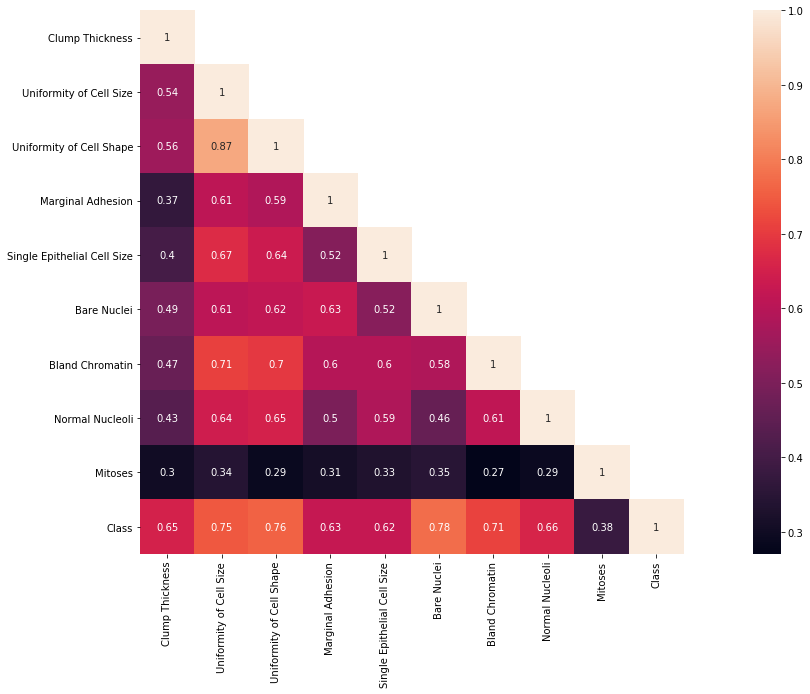

In [16]:
cm = data_train.corr() # Compute pairwise correlation of columns
mask = np.array(cm)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(25,10)
sn.heatmap(data=cm, mask=mask, square=True, annot=True, cbar=True)
plt.show()

By looking at the confusion matrix, it is possible to see a high correlation between Uniformity of Cell Size and Uniformity of Cell Shape, so we can definitely drop one of them

In [17]:
data_train = data_train.drop('Uniformity of Cell Size', axis=1)
data_test = data_test.drop('Uniformity of Cell Size', axis=1)

## 2.2. Dataset balancing

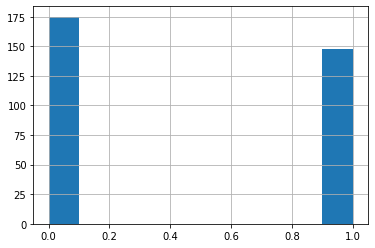

In [18]:
data_train['Class'].hist()
plt.show()

As we can see for the classes distirbution, there is no huge difference between two classes so we actually choose to do not upsample/downsample the dataset

# 3. Classification

## 3.0. Preliminary

Before going deeper into each model, we always need to decide all the tools that will help us during the training process, that means defining the right metrics and how to validate the model.

### 3.0.1. Metrics

We need to remember that we are in the medical field, which means that not all erros are equal. In this case, predicting a tumour as benign when in fact it is malignant is more serious than predicting a benign tumour as malignant.<br>Hence, I have to be very sure before predicting a tumour as benign.<br>This suggests that a simple accuracy it is not suitable for this task. In order to have an overview of the model about how confident a model is about its predictions and how many of all the cases it's able to capture we respectively need Precision and Recall.

<div style="text-align: center">$precision = \frac{TP}{TP + FP},$   &nbsp;        $recall = \frac{TP}{TP + FN},$</div>

<div style="text-align: center">where:<em>  TP=TruePositive, FP=FalsePositive, FN=FalseNegative, TN=TrueNegative</em></div>

<div style="text-align: center">$\begin{bmatrix} TP & FN  \\ FP & TN \end{bmatrix}$</div>

### 3.0.2. K-fold Cross Validation

Cross-validation is a procedure that aims to resample the dataset to improve the performance of the machine learning model.<br>More specifically, the term K-fold stands for the number of bucket which the training dataset is divided. The procedure consists of using K-1 fold for training and the remaining fold for validating the model, the process is repeated K times in rotation on all the fold.<br>Regaring the value of K, this should be chosen such that the training set and validation set are larger enough to be a consistent representation of the underlying dataset. Several empirical studies has shown that K=5 or K=10 is in general a good choice.<br>At the end of the process, the performance of the model is the average of the K different models. Furthermore, as a good practice, usually one takes the set of hyperparameters values that has higher average cross-validation performance and now re-train with these values on the whole training set, this will be the (best) validated model to be used for testing.<br>As can be seen, by adopting this type of process the model is less sensitive to the data on which it is trained and validated, this generally leads to the choice of a model with better generalisation capabilities and therefore better performance on the test set.<br><br>Furthermore, there are also sophisticated variants of the proposed method, among them the Stratified K-Fold Cross Validation is very interesting as each fold contains the same percentage of samples as in the original dataset; this is a useful technique when dealing with data unbalancing.

In [19]:
K = 5
skf = StratifiedKFold(n_splits=K)

### 3.0.3. Grid Search

In [20]:
# HARD-CODED parameters for GridSearchCV function

# DOC:
# - precision_score of the bening class is the metric the we use to validate
#    and consequently find the optimal model
# - pos_label==0 since we are interested in validate our model
#    according to the precision score of the benign class(that has label==0)
# - refit==True since after finding the best hyperparameters values through
#    cross-validation we re-train the best model with this setting on the 
#    whole dataset

precision_score_plzero = make_scorer(precision_score, pos_label=0, zero_division=0)
kwargs = {
    'cv': skf,
    'scoring': precision_score_plzero,
    'refit': True,
}

It is the most common and simple way of performing hyperparameter optimization; it consists in determining a set of values for each hyperparameter and then run a model for each combination of them in order to find the best one.<br>Usually, it's a good practice (in order to save time) to run first a coarse-grain grid search in order to understand which is the best range of values for each hyperparameter, after that a fine-grain grid search can be run in order to find the optimal value for each hyperparameter.

## 3.1. Logistic Regression

Logistic regression is a model originally developed for binary classification. It has the particularity of not directly modelling the categorical label, in fact it is based on the linear regression, but the output is modelled in such a way that range from 0 to 1, here we set a threshold for discriminating between two classes.<br><br>Linear Regression has the following form: 

$$p(X) = \beta_0 + \beta_1X,$$   

now, in order to convert the output in range 0 to 1, we use the <em>logistic function:</em>

$$p(X) = \frac{\exp(\beta_0 + \beta_1X)}{1 + \exp(\beta_0 + \beta_1X)}$$.

After a bit of math on the above formula, we can use the MLE(<em>Maximum Likelihood Estimation</em>) method in order to find the best values for the model parameters $\beta_0$ and $\beta_1$.<br>In a nutshell, MLE is a "likelihood" maximization method which aims to find the values of the parameters such that are most likely to produce the observed data.<br><br>Here we list the main hyperparameters for Logistic Regression: 
* <b>penalty</b>: indicate the norm to use as regularization
* <b>C</b>: it is the strength of the regularization, smaller values specify stronger regularization
* <b>solver</b>: algorithm to use for the optimization problem

BEST PARAMS: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
MEAN 5-FOLD PRECISION: 94.9%
TEST SET PRECISION: 92.1%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        59
           1       0.98      0.91      0.94        54

    accuracy                           0.95       113
   macro avg       0.95      0.95      0.95       113
weighted avg       0.95      0.95      0.95       113



CONFUSION MATRIX:


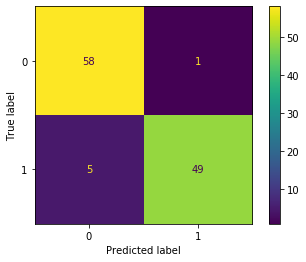



Apply PCA with n_components=2

BEST PARAMS: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
MEAN 5-FOLD PRECISION: 94.3%
TEST SET PRECISION: 93.5%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        59
           1       0.98      0.93      0.95        54

    accuracy                           0.96       113
   macro avg       0.96      0.95      0.96       113
weighted avg       0.96      0.96      0.96       113



CONFUSION MATRIX:


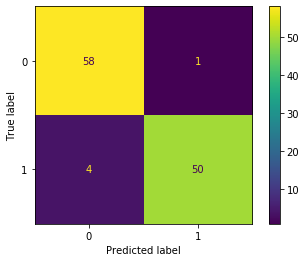



DECISION BOUNDARY:


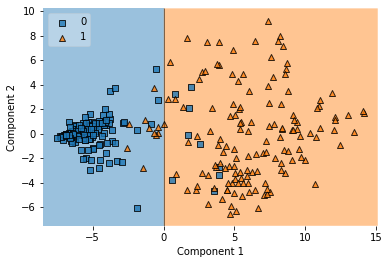

In [64]:
params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1.0, 10.0],
    'solver': ['liblinear'],
}

X = data_train.drop(['Class'], axis=1)
y = data_train['Class']

log_reg = LogisticRegression(random_state=SEED)
clf = GridSearchCV(log_reg, params, **kwargs)
clf.fit(X, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

log_reg = clf.best_estimator_
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']
y_pred = log_reg.predict(X_test)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(log_reg, X_test, y_test)*100))

y_pred = log_reg.predict(X_test)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(log_reg, X_test, y_test)
plt.show()


print('\n===============================\n')
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS)
print('Apply PCA with n_components=2\n')

X_pca = pca.fit_transform(X)

log_reg_pca = LogisticRegression(random_state=SEED)
clf = GridSearchCV(log_reg_pca, params, **kwargs)
clf.fit(X_pca, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

log_reg_pca = clf.best_estimator_
X_test_pca = pca.transform(X_test)
y_pred_pca = log_reg_pca.predict(X_test_pca)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(log_reg_pca, X_test_pca, y_test)*100))

y_pred = log_reg_pca.predict(X_test_pca)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(log_reg_pca, X_test_pca, y_test)
plt.show()

print('\n\nDECISION BOUNDARY:')
plot_decision_regions(X=X_pca, y=y.to_numpy(), clf=log_reg_pca, legend=N_COMPONENTS)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## 3.2. Decision Tree

Decision Tree is a model that can be used both for regression and classification problems.<br>This technique consists in building a set of rules that predict the output in a step-by-step, greedy way. Such rules are arranged in a tree structure, whose internal nodes are boolean conditions on the attibutes that lead to a unique prediction for each input sample. During the construction of the tree, we continue to make splits until a certain minimum number of samples or a maximum depth of the tree decided a priori is reached. Then when a new sample arrives to assign a class you follow the appropriate path through the tree until you arrive to a leaf that will give the prediction for that sample.<br><br>From a more technical point of view, in a nutshell, we are using recursive binary splitting to grow a classification tree.<br><br>During the training(i.e. the construction) of the tree, since we are in a classification problem, it comes naturally to use the <em>classification error rate</em>, however, it turns out that the constructed decision tree is not sufficiently sensitive.<br>Therefore, two measures need to be introduced, the gini index: $$G = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$$ while the cross-entropy is: $$D = -\sum_{k=1}^K \hat{p}_{mk} log \hat{p}_{mk}$$Here, $K$ is the number of classes and $\hat{p}_{mk}$ represents the proportion of training observations in the $m$th region that are from the $k$th class.<br><br>As you can easily guess from the above, there are some hyper-parameters to tune, among them:
* <b>max_depth</b>: it's a stopping criteria; the maximum depth of the three
* <b>criterion</b>: which of the two above-mentioned measures to use to evaluate a split
* <b>min_samples_split</b>: it's a stopping criteria; represents the minimum number of samples required to do a split
* <b>min_samples_leaf</b>: a split S is made (and so the internal node N is generated) only if every leaves that will belong to the sub-tree with root at N will have at least min_samples_leaf samples

BEST PARAMS: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 35}
MEAN 5-FOLD PRECISION: 94.9%
TEST SET PRECISION: 87.9%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        59
           1       0.98      0.85      0.91        54

    accuracy                           0.92       113
   macro avg       0.93      0.92      0.92       113
weighted avg       0.93      0.92      0.92       113



CONFUSION MATRIX:


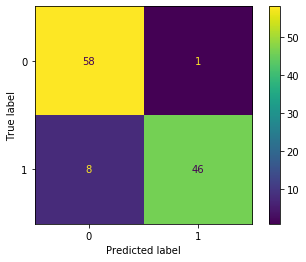



Apply PCA with n_components=2

BEST PARAMS: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 40}
MEAN 5-FOLD PRECISION: 98.8%
TEST SET PRECISION: 98.2%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        59
           1       0.95      0.98      0.96        54

    accuracy                           0.96       113
   macro avg       0.96      0.97      0.96       113
weighted avg       0.97      0.96      0.96       113



CONFUSION MATRIX:


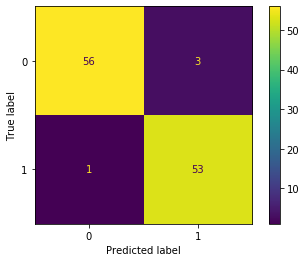



DECISION BOUNDARY:


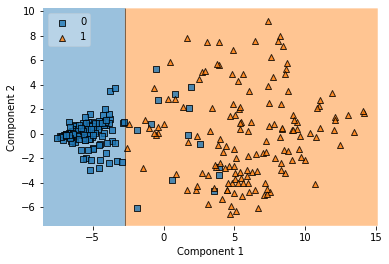

In [67]:
params = {
    'max_depth': np.arange(start=10, stop=101, step=10).tolist(),
    'criterion': ['gini', 'entropy'],
    'min_samples_split': np.arange(start=5, stop=101, step=5).tolist(),
    'min_samples_leaf': np.arange(start=5, stop=101, step=5).tolist(),
}

X = data_train.drop(['Class'], axis=1)
y = data_train['Class']

dec_tree = DecisionTreeClassifier(random_state=SEED)
clf = GridSearchCV(dec_tree, params, **kwargs)
clf.fit(X, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

dec_tree = clf.best_estimator_
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']
y_pred = dec_tree.predict(X_test)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(dec_tree, X_test, y_test)*100))

y_pred = dec_tree.predict(X_test)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(dec_tree, X_test, y_test)
plt.show()


print('\n===============================\n')
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS)
print('Apply PCA with n_components=2\n')

X_pca = pca.fit_transform(X)

dec_tree_pca = DecisionTreeClassifier(random_state=SEED)
clf = GridSearchCV(dec_tree_pca, params, **kwargs)
clf.fit(X_pca, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

dec_tree_pca = clf.best_estimator_
X_test_pca = pca.transform(X_test)
y_pred_pca = dec_tree_pca.predict(X_test_pca)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(dec_tree_pca, X_test_pca, y_test)*100))

y_pred = dec_tree_pca.predict(X_test_pca)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(dec_tree_pca, X_test_pca, y_test)
plt.show()

print('\n\nDECISION BOUNDARY:')
plot_decision_regions(X=X_pca, y=y.to_numpy(), clf=dec_tree_pca, legend=N_COMPONENTS)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

FIRST DECISION TREE:


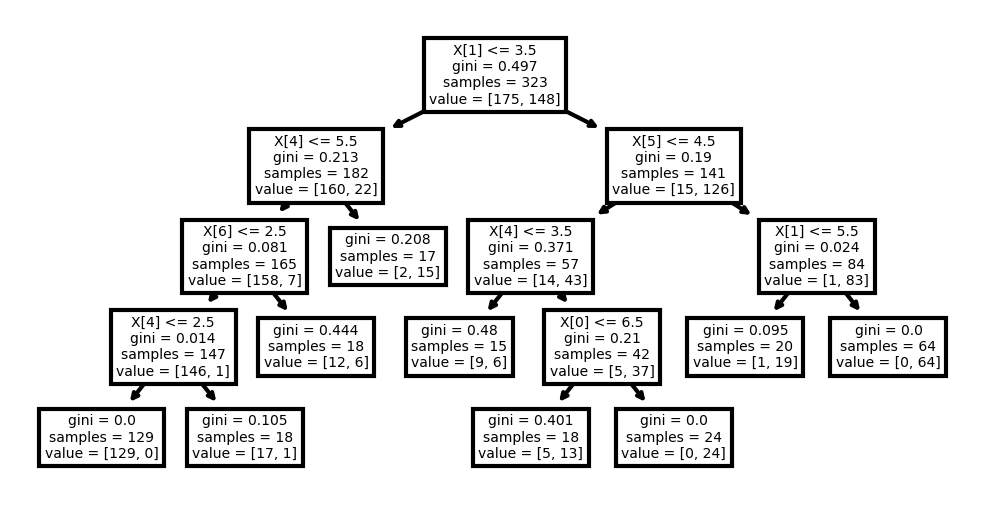

In [80]:
print('FIRST DECISION TREE:')
plt.subplots(nrows = 1,ncols = 1,figsize = (4,2), dpi=300)
plot_tree(dec_tree)
plt.show()

SECOND DECISION TREE(PCA APPLIED):


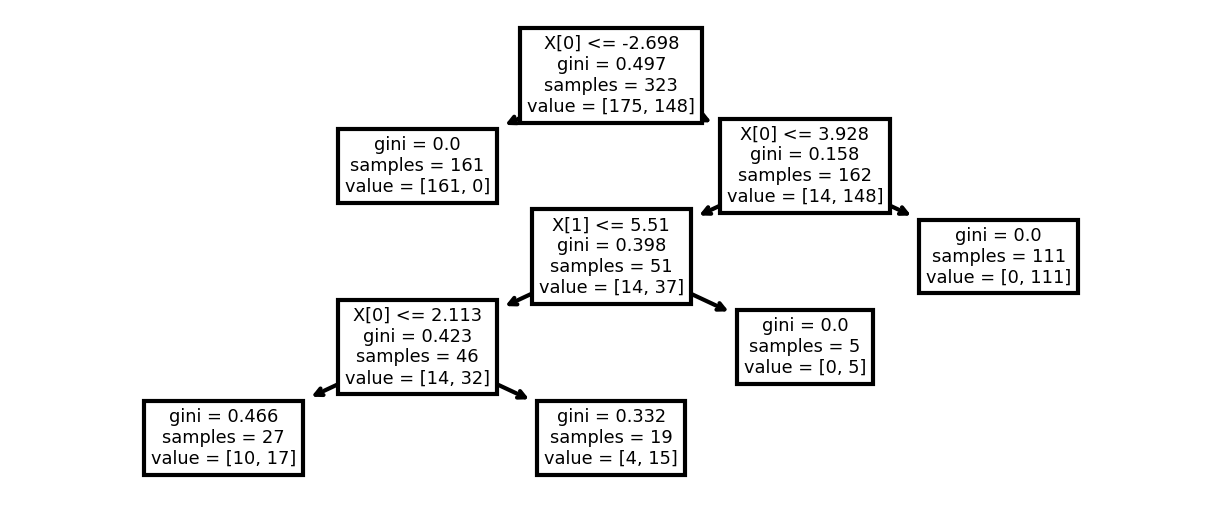

In [81]:
print('SECOND DECISION TREE(PCA APPLIED):')
plt.subplots(nrows = 1,ncols = 1,figsize = (5,2), dpi=300)
plot_tree(dec_tree_pca)
plt.show()

## 3.3. Random Forest

### 3.3.0 Bagging

Before diving into the random forest model, it is good to make a short digression to introduce what is the general idea behind this model.<br><em>Bootstrap</em> it's a sampling technique in which given a training set M made up of N samples, we create others B datasets (bootstrapped dataset) containing N samples as well. Each bootstrapped dataset <em>b</em>, is filled by sampling uniformly with replacement from M.<br><em>Bagging(bootstrap aggregating)</em>, is an ensemble method where the machine learning model on each one of the B bootstrapped datasets, so at the end we will have B different trained models, at inference time the prediction is the average over the predictions of the models.<br>As you might guess, this technique will leave the bias unchanged while trying to reduce the variance.

<b>Random forest</b> is a powerful ensemble method, usually it represents an off-the-shelf model for most data mining use cases.<br>It can be viewed as a "fusion" of decision tree and bagging. This is motivated by the fact that it is well known that decision tree model suffers of high variance (while bias is low), so bagging is particulary useful in this case.<br>To be more precise, Random forest carries an improvement over the bagging method, with the aim of building <em>de-correlated</em> trees. This is achieved by training each decision tree on a randomly sampled subset of features (usually $\sqrt{\rho}$, where $\rho$ is the number of features of the input data). The intuition behind is that, intuitively, reducing the numer of features used will reduce the correlation between any pair of trees in the ensemble, and hence reduce the variance.<br><br>Notice that random forest, due to its ensemble nature, loses the much desired interpretability feature that the decision tree had successfully achieved.

Random forest introduces new hyperparameters to tune (in addition to those inherited from the decision tree):
* <b>n_estimators</b>: the number of models (decision trees in this case) of which the esemble is composed
* <b>max_features</b>: the number of random features to consider on each split

BEST PARAMS: {'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 15, 'min_samples_split': 35, 'n_estimators': 190}
MEAN 5-FOLD PRECISION: 97.1%
TEST SET PRECISION: 96.6%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        59
           1       0.96      0.96      0.96        54

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113



CONFUSION MATRIX:


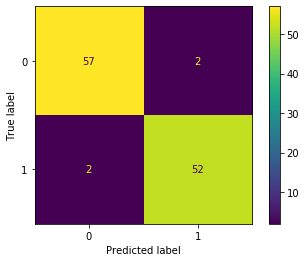



Apply PCA with n_components=2

BEST PARAMS: {'criterion': 'gini', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 15, 'min_samples_split': 35, 'n_estimators': 20}
MEAN 5-FOLD PRECISION: 98.8%
TEST SET PRECISION: 98.3%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.96      0.98      0.97        54

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CONFUSION MATRIX:


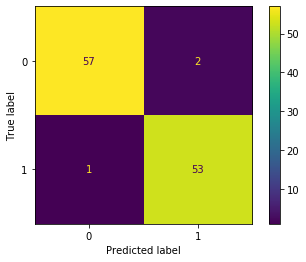



DECISION BOUNDARY:


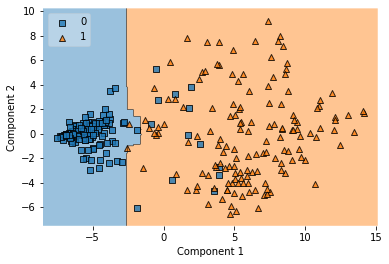

In [93]:
# due to time constraints, we take the best decision 
# tree hyperparameters previously obtained instead 
# of re-tuning them
params = {
    'max_depth': [dec_tree.max_depth],
    'criterion': [dec_tree.criterion],
    'min_samples_split': [dec_tree.min_samples_split],
    'min_samples_leaf': [dec_tree.min_samples_leaf],
    'n_estimators': np.arange(start=80, stop=201, step=10).tolist(),
    'max_features': np.arange(start=1, stop=data_train.drop(['Class'], axis=1).shape[1], step=1).tolist(),
}

X = data_train.drop(['Class'], axis=1)
y = data_train['Class']

rand_for = RandomForestClassifier(random_state=SEED)
clf = GridSearchCV(rand_for, params, **kwargs)
clf.fit(X, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

rand_for = clf.best_estimator_
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']
y_pred = rand_for.predict(X_test)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(rand_for, X_test, y_test)*100))

y_pred = rand_for.predict(X_test)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(rand_for, X_test, y_test)
plt.show()


print('\n===============================\n')
N_COMPONENTS = 2
params['max_features'] = np.arange(start=1, stop=N_COMPONENTS+1, step=1).tolist()
params['n_estimators'] = np.arange(start=5, stop=81, step=5).tolist()
pca = PCA(n_components=N_COMPONENTS)
print('Apply PCA with n_components=2\n')

X_pca = pca.fit_transform(X)

rand_for_pca = RandomForestClassifier(random_state=SEED)
clf = GridSearchCV(rand_for_pca, params, **kwargs)
clf.fit(X_pca, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

rand_for_pca = clf.best_estimator_
X_test_pca = pca.transform(X_test)
y_pred_pca = rand_for_pca.predict(X_test_pca)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(rand_for_pca, X_test_pca, y_test)*100))

y_pred = rand_for_pca.predict(X_test_pca)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(rand_for_pca, X_test_pca, y_test)
plt.show()

print('\n\nDECISION BOUNDARY:')
plot_decision_regions(X=X_pca, y=y.to_numpy(), clf=rand_for_pca, legend=N_COMPONENTS)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## 3.4. Support Vector Machine

Support Vector Machine is a classification method that aims to find an hyperplane able to perfectly separare the classes.<br>An <em>hyperplane</em> is a linear subspace of dimension $(n - 1)$, where $n$ is the input features dimension.<br>The hyperplane is defined as follows: $\{x: f(x) = x^T\beta + \beta_0 = 0\}$ and, for a binary classification problem with labels $y ∈ \{-1, 1\}$ the classificaiton rule induced by $f(x)$ is: $G(x) = sign[x^T\beta + \beta_0]$<br><br>In particular, the SVM wants to find the <em>biggest margin</em> between training points belonging to different classes. This means solving the following optimization problem: $${max}_{\beta, \beta_0, ||\beta||=1} M$$ <br><div style="text-align: center">subject to $y_i(x_i^T\beta + \beta_0) \ge M, i=1,...N$</div>

The situation becomes more complicated if the two classes are overlapping in the feature space. A very first intuitive solution is to still maximize $M$, but allow for some points to on the on wrong side of the margin.<br>Hence, we need to define slack variables: $\xi = (\xi_1, \xi_2,...,\xi_N)$, and the constraint above becomes:<br><br> $$y_i(x_i^T\beta + \beta_0) \ge M - \xi_i$$

It is important to note that, once the SVM is trained, we can only keep the training points close to the boundary found to correcly do classification at inference time, this points are called <em>support vectors</em>. Furthermore, if we are in the case involving slack variables, also the points on the wrong side of the bondary (i.e. the misclassified ones) are support vectors.

The SVM described so far finds linear boundaries in the input feature space. When this is not possible, in addition to try to mitigate this problem by means of slack variables, another more ad hoc solution it to project the input feature space in a higher dimensional feature space, with the aim of finding the hyperplane in this new space. When projecting back the boundary into the original feature space, this results in a non-linear boundary.

First of all, we need to define a function $\phi$ such that the input vector is projected into a high-dimensional space, this function specify how to transform each element of the vector and how the new dimension is created.<br> 
Example: $$x = {x_1 \choose x_2}, \quad \phi(x)=\phi({x_1 \choose x_2})=\begin{pmatrix} x_1^2 \\ \sqrt{2} \text{  } x_1x_2  \\ x_2^2 \end{pmatrix}$$

However, since this transformation can lead to a very high computational cost, in real applications the well-know <em>kernel trick</em> is used to overcome this limitation.<br>The "trick" consists in instead of explicitly applying the transformation $\phi(x)$, we compute only the dot product of the two transformed vectors, relying on the fact that the objective function we are optimizing to fit the higher dimensional space comprises only the dot product of the transformed feature vectors (and no other operation on them).<br>Therefore, in a nutshell, a kernel function is a function that accepts inputs in the original lower dimensional space and returns the dot product of the transformed vectors in the higher dimensional space. We define the kernel function $k$ as:
$$x, z ∈ X, \quad \phi:X \rightarrow \mathbb{R}^N, \quad k(x, z) = <\phi(x), \phi(z)> $$

Hyperparameters to tune:
* <b>C</b>: regularization parameter, it tells the svm optimization how much you want to avoid miss classifying each training example. Higher value means harder margin
* <b>kernel</b>: the kernel function to use
* <b>gamma</b>: in case of 'rbf' or 'poly' kernel, this means how far the influence of a single training sample reaches. Higher value means considering samples closer to the margin

BEST PARAMS: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
MEAN 5-FOLD PRECISION: 95.9%
TEST SET PRECISION: 96.7%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97        59
           1       0.98      0.96      0.97        54

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CONFUSION MATRIX:


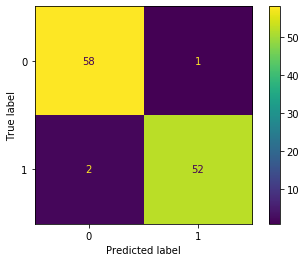



Apply PCA with n_components=2

BEST PARAMS: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True}
MEAN 5-FOLD PRECISION: 98.3%
TEST SET PRECISION: 98.3%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.96      0.98      0.97        54

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CONFUSION MATRIX:


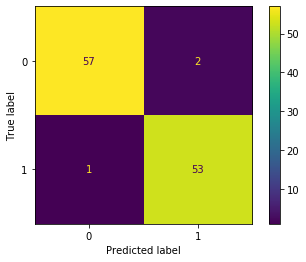



DECISION BOUNDARY:


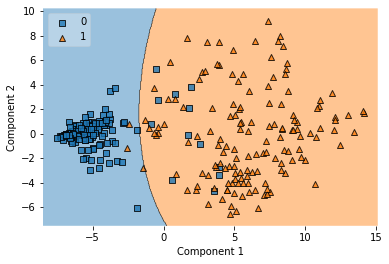

In [103]:
params = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [1e-3, 1e-4, 1e-5],
    'probability': [True]
}

X = data_train.drop(['Class'], axis=1)
y = data_train['Class']

svm = SVC(random_state=SEED)
clf = GridSearchCV(svm, params, **kwargs)
clf.fit(X, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

svm = clf.best_estimator_
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']
y_pred = svm.predict(X_test)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(svm, X_test, y_test)*100))

y_pred = svm.predict(X_test)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(svm, X_test, y_test)
plt.show()


print('\n===============================\n')
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS)
print('Apply PCA with n_components=2\n')

X_pca = pca.fit_transform(X)

svm_pca = SVC(random_state=SEED)
clf = GridSearchCV(svm_pca, params, **kwargs)
clf.fit(X_pca, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

svm_pca = clf.best_estimator_
X_test_pca = pca.transform(X_test)
y_pred_pca = svm_pca.predict(X_test_pca)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(svm_pca, X_test_pca, y_test)*100))

y_pred = svm_pca.predict(X_test_pca)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(svm_pca, X_test_pca, y_test)
plt.show()

print('\n\nDECISION BOUNDARY:')
plot_decision_regions(X=X_pca, y=y.to_numpy(), clf=svm_pca, legend=N_COMPONENTS)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## 3.5. K-nearest Neighbors

The idea behind this algorithm is to assign samples which are “near” to each other to the same class. Despite its trivial implementation, this algorithm is used in many real cases, which makes its results easier to understand than more complex algorithms such as logistic regression or support vector machines.<br>The main factor characterising this algorithm is its different behavior, in terms of computation, during training and test phases. In fact, it does not have a real training computation, since during this phase we only need to store all of the samples (i.e. training very fast), while during testing we need to compute the distances between the test sample and each training sample (i.e. inference very slow).<br>Furthermore, since its strictly dependance on the distance, attributes must be carefully normalized, and apart from this one can easily guess that this algorithm suffers a lot the curse of dimensionality, since in a high-dimensional space samples are very far from each other and distance metrics lose any significance.

Hyperparameters to tune:
* <b>n_neighbors</b>: the number of neighbors to be used to give the prediction
* <b>weights:</b>: whether or not to weight neighbors by the inverse of their distance
* <b>p</b>: power parameter of the Minkowski metric (e.g. manhattan or euclidean distance)

BEST PARAMS: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
MEAN 5-FOLD PRECISION: 96.0%
TEST SET PRECISION: 92.1%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        59
           1       0.98      0.91      0.94        54

    accuracy                           0.95       113
   macro avg       0.95      0.95      0.95       113
weighted avg       0.95      0.95      0.95       113



CONFUSION MATRIX:


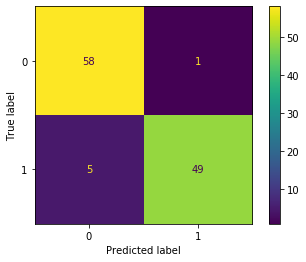



Apply PCA with n_components=2

BEST PARAMS: {'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
MEAN 5-FOLD PRECISION: 98.3%
TEST SET PRECISION: 98.3%


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97        59
           1       0.96      0.98      0.97        54

    accuracy                           0.97       113
   macro avg       0.97      0.97      0.97       113
weighted avg       0.97      0.97      0.97       113



CONFUSION MATRIX:


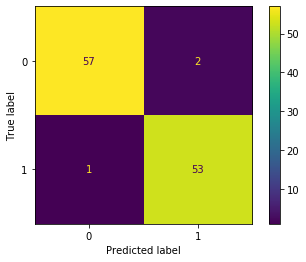



DECISION BOUNDARY:


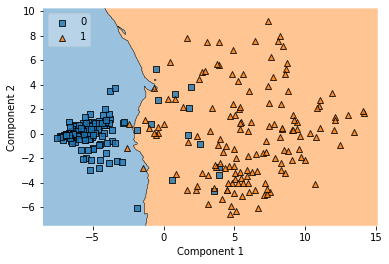

In [99]:
params = {
    'n_neighbors': [3, 5, 7, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

X = data_train.drop(['Class'], axis=1)
y = data_train['Class']

knn = KNeighborsClassifier()
clf = GridSearchCV(knn, params, **kwargs)
clf.fit(X, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

knn = clf.best_estimator_
X_test = data_test.drop(['Class'], axis=1)
y_test = data_test['Class']
y_pred = knn.predict(X_test)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(knn, X_test, y_test)*100))

y_pred = knn.predict(X_test)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(knn, X_test, y_test)
plt.show()


print('\n===============================\n')
N_COMPONENTS = 2
pca = PCA(n_components=N_COMPONENTS)
print('Apply PCA with n_components=2\n')

X_pca = pca.fit_transform(X)

knn_pca = KNeighborsClassifier()
clf = GridSearchCV(knn_pca, params, **kwargs)
clf.fit(X_pca, y)
print('BEST PARAMS:', clf.best_params_)
print('MEAN 5-FOLD PRECISION: {:.1f}%'.format(clf.best_score_*100))

knn_pca = clf.best_estimator_
X_test_pca = pca.transform(X_test)
y_pred_pca = knn_pca.predict(X_test_pca)
print('TEST SET PRECISION: {:.1f}%\n\n'.format(precision_score_plzero(knn_pca, X_test_pca, y_test)*100))

y_pred = knn_pca.predict(X_test_pca)

print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred))

print('\n\nCONFUSION MATRIX:')
plot_confusion_matrix(knn_pca, X_test_pca, y_test)
plt.show()

print('\n\nDECISION BOUNDARY:')
plot_decision_regions(X=X_pca, y=y.to_numpy(), clf=knn_pca, legend=N_COMPONENTS)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## 3.6. Model Comparison

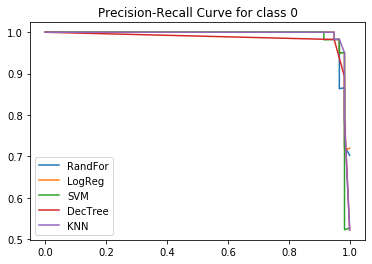

In [117]:
rand_for_probs = rand_for_pca.predict_proba(X_test_pca)
log_reg_probs = log_reg_pca.predict_proba(X_test_pca)
svm_probs = svm_pca.predict_proba(X_test_pca)
dec_tree_probs = dec_tree_pca.predict_proba(X_test_pca)
knn_probs = knn_pca.predict_proba(X_test_pca)

prec, rec, _ = precision_recall_curve(y_test, rand_for_probs[:, 0], pos_label=0)
plt.plot(rec, prec, label='RandFor')
prec, rec, _ = precision_recall_curve(y_test, log_reg_probs[:, 0], pos_label=0)
plt.plot(rec, prec, label='LogReg')
prec, rec, _ = precision_recall_curve(y_test, svm_probs[:, 0], pos_label=0)
plt.plot(rec, prec, label='SVM')
prec, rec, _ = precision_recall_curve(y_test, dec_tree_probs[:, 0], pos_label=0)
plt.plot(rec, prec, label='DecTree')
prec, rec, _ = precision_recall_curve(y_test, knn_probs[:, 0], pos_label=0)
plt.plot(rec, prec, label='KNN')

plt.title('Precision-Recall Curve for class 0')
plt.legend()
plt.show()

# 4. Bibliography

1. Friedman et al., 2001, The Elements of Statistical Learning
2. Witten et al., 2013, An Introduction to Statistical Learning